# Proyecto de Predicción "Clasificador De Pokémones"

El carácter de este proyecto es netamente educativo, su objetivo es hacer una demostración paso a paso de cómo entrenar un modelo de aprendizaje supervisado para la clasificación de datos en base a características compartidas entre categorías en un Dataset, utilizando varios modelos basados en árboles de decisión de la librería Scikit-Learn.

El Dataset que utilizaremos está contenido dentro de esta carpeta como 'Pokemon.csv'; la descripción de este Dataset y sus variables también se encuentra en esta carpeta como 'Pokemon_summary.txt'. El archivo 'Pokemon.csv' fue adaptado de: https://www.kaggle.com/datasets/rounakbanik/pokemon

La razón por la que utilizaremos este Dataset es porque es relativamente pequeño (1072 datos); fácil de entender y explicar; presenta datos de tipo String, Int, y categóricos; y requiere de preprocesamiento, pues tiene algunos errores de imputación y datos atípicos. Además de esto, el Dataset presenta varias variables categóricas que pueden ser usadas para predicciones.

Algunos de los desafíos que vamos a enfrentar con este Dataset incluyen:

* Valores atípicos severos
* Categorías desbalanceadas
* Datos mal escritos
* Valores faltantes
* Datos repetidos

Además, algunos de los desafíos que vamos a enfrentar a la hora de entrenar los modelos incluyen:

* Identificación de tendencias
* Evaluación de métricas
* Selección de métricas correctas para un Dataset desbalanceado
* Corrección de sobreajuste
* Variables irrelevantes.


## 1. Definición del problema

La primera pregunta que nos debemos hacer es ¿'Qué queremos predecir?', este Dataset contine múltiples variables de tipo categóricas y una variable de tipo Booleano que son buenas candidatas para ser utilizadas como etiquetas, siendo así, podríamos entrenar múltiples modelos de predicción con diferentes objetivos utilizando el mismo Dataset, por ejemplo:

* Predecir si un Pokémon es de tipo legendario
* Predecir el tipo principal de un Pokémon
* Predecir el tipo secundario de un Pokémon
* Predecir la generación a la que pertenece un Pokémon

También podemos realizar predicciones combinadas entre las propuestas anteriores, por ejemplo, podemos predecir el tipo principal y el secundario de un Pokémon; o predecir su generación y si es o no legendario (aunque estas combinaciones tomarán mayor preprocesamiento y preparación de los datos para el modelo).

Para este proyecto, sin embargo, crearemos un modelo que prediga la clase booleana 'legendary', pues sabemos, gracias al material de origen, que esta etiqueta está directamente correlacionada con las demás características


## 2. Preprocesamiento

Iniciaremos haciendo un análisis exploratorio de los datos: cargaremos el DataFrame, revisaremos que los tipos de los datos estén bien cargados, y si hay datos faltantes en el Dataset tomaremos decisiones respecto a estos.

Posteriormente a esto revisaremos las variables numéricas más a fondo para buscar datos atípicos y encontrar una explicación para estos (por ejemplo, datos mal escritos o datos diferentes por diseño).


### 2.1 Variables categóricas y tipo String

Empecemos cargando el DataFrame y analizando los tipos de datos que Pandas asignó a cada variable.

In [1239]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


# Ignoramos las alertas de versión para mayor legibilidad
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/Pokemon.csv')

# Asignamos un valor 'seed' para reproducibilidad
np.random.seed(42)

print('Tipos de las columnas leídos por Pandas\n')
print(df.info())

Tipos de las columnas leídos por Pandas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   number      1072 non-null   int64 
 1   name        1072 non-null   object
 2   type1       1072 non-null   object
 3   type2       574 non-null    object
 4   total       1072 non-null   int64 
 5   hp          1072 non-null   int64 
 6   attack      1072 non-null   int64 
 7   defense     1072 non-null   int64 
 8   sp_attack   1072 non-null   int64 
 9   sp_defense  1072 non-null   int64 
 10  speed       1072 non-null   int64 
 11  generation  1072 non-null   int64 
 12  legendary   1072 non-null   bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 101.7+ KB
None


Como determinamos anteriormente, 'type1', 'type2', 'generation' y 'legendary' son posibles etiquetas de tipo categóricas y es tipo booleano.

Sabiendo esto, analizaremos primero las variables de tipo object, para asegurarnos de que sus datos estén correctos, y realizaremos cualquier preprocesamiento necesario.

In [1240]:
# Estandarizamos la escritura de los datos tipo String
df['name'] = df['name'].str.title()
df['type1'] = df['type1'].str.title()
df['type2'] = df['type2'].str.title()

print('\nAnalisis de las columnas de texto:\n')
print('Datos únicos de name:', len(df.name.unique()),
      '\nDatos únicos de type1:', len(df.type1.unique()),
      '\nDatos únicos de type2:', len(df.type2.unique()),
      '\nDatos únicos de generation:', len(df.generation.unique()))

print('\nDatos únicos de type1, type2 y generation:\n')
print(df['type1'].value_counts(), '\n')
print(df['type2'].value_counts(), '\n')
print(df['generation'].value_counts())


Analisis de las columnas de texto:

Datos únicos de name: 1072 
Datos únicos de type1: 20 
Datos únicos de type2: 19 
Datos únicos de generation: 9

Datos únicos de type1, type2 y generation:

type1
Water        136
Normal       117
Grass         94
Bug           83
Psychic       80
Fire          67
Electric      63
Rock          60
Dark          48
Fighting      45
Ghost         43
Poison        42
Ground        42
Dragon        41
Steel         39
Ice           38
Fairy         23
Flying         9
Blastoise      1
Graass         1
Name: count, dtype: int64 

type2
Flying      114
Fairy        44
Psychic      43
Poison       41
Ground       39
Steel        36
Dragon       35
Fighting     32
Grass        29
Dark         28
Ghost        26
Water        22
Ice          19
Fire         18
Rock         16
Normal       11
Electric     11
Bug          10
Name: count, dtype: int64 

generation
1    178
5    166
3    160
8    139
4    121
7    114
2    106
6     85
0      3
Name: count, dtype

Analizando los datos únicos resultantes de ambas columnas, encontramos varios problemas:

* 'type2' tiene una gran cantidad de datos faltantes.
* 'type1' tiene datos mal escritos.
* 'generation' tiene un valor 0 (las generaciones de Pokémon empiezan por la 1).
* 'name' tiene dos datos repetidos (No tocaremos esto, pues los datos repetidos de 'name' resultan ser los datos que tienen 'type1' mal escrito)

Primero lidiaremos con los datos faltantes de type2.

Un análisis del Dataset y de su material de origen revela que los datos faltantes no son aleatorios: un dato faltante en type2 significa que el Pokémon no tiene un tipo secundario, por lo tanto, imputaremos los datos faltantes como una nueva categoría ‘None’.

**SIEMPRE es importante, antes de iniciar con un análisis de datos exploratorio, familiarizarse con el Dataset**, es gracias a esto que supimos diferenciar los datos categóricos de los numéricos, las posibles etiquetas, y es por esto que sabemos que 'type2' no tiene valores faltantes aleatorios.


In [1241]:
df['type2'] = df['type2'].fillna('None')
print(df['type2'].value_counts())

type2
None        498
Flying      114
Fairy        44
Psychic      43
Poison       41
Ground       39
Steel        36
Dragon       35
Fighting     32
Grass        29
Dark         28
Ghost        26
Water        22
Ice          19
Fire         18
Rock         16
Normal       11
Electric     11
Bug          10
Name: count, dtype: int64


Para 'type1', eliminaremos todas las entradas que están mal escritas. Encontrar datos mal escritos puede ser complicado en Datasets de gran tamaño, generalmente requiere de la aplicación de algoritmos de aprendizaje de máquina relacionados con similitud de texto como los que utilizan los auto correctores de los celulares.

Sin embargo, en este caso sabemos que los datos de 'type1' van a ser nuestras etiquetas, y pertenecen a categorías limitadas, con lo cual podemos considerar un dato 'mal escrito' como una categoría que solo tenga uno o dos representantes.

Considerando esto, eliminaremos todos los datos que contengan un valor de 'type1' que se repita menos de 5 veces (valor escogido arbitrariamente, pues en este caso los podríamos eliminar manualmente, pero el código no sería reutilizable).


In [1242]:
categories = df['type1'].value_counts()
categories = categories[categories[categories.index] > 5]

df = df[df['type1'].isin(categories.index)]

print(df['type1'].value_counts())

type1
Water       136
Normal      117
Grass        94
Bug          83
Psychic      80
Fire         67
Electric     63
Rock         60
Dark         48
Fighting     45
Ghost        43
Poison       42
Ground       42
Dragon       41
Steel        39
Ice          38
Fairy        23
Flying        9
Name: count, dtype: int64


Finalmente, revisaremos los datos categorizados como 'generación 0', pues no existe una generación 0 en Pokémon.

In [1243]:
print(df[df['generation'] == 0])

     number                 name  type1 type2  total   hp  attack  defense  \
950     808               Meltan  Steel  None    300   46      65       65   
951     809             Melmetal  Steel  None    600  135     143      143   
952     809  Gigantamax Melmetal  Steel  None    600  135     143      143   

     sp_attack  sp_defense  speed  generation  legendary  
950         55          35     34           0       True  
951         80          65     34           0       True  
952         80          65     34           0       True  


Investigando, encontramos que este Pokémon (y sus dos variables también aquí presentes) fue introducido en un videojuego secundario de la saga, no en uno de los principales, con lo que el DataFrame clasifica su generación como 0. Sin embargo, de acuerdo a la wiki del juego, el videojuego en el que fue introducido está situado en la séptima generación, por lo tanto, le imputaremos este valor.

In [1244]:
df['generation'].replace(0, 7, inplace=True)

print(df['generation'].value_counts())

generation
1    177
5    166
3    160
8    138
4    121
7    117
2    106
6     85
Name: count, dtype: int64


Si una variable de texto consiste en unos pocos valores únicos que se repiten muchas veces, es buena idea pasarla a tipo categórica, pues este tipo de variable consume mucho menos espacio en memoria que variables String, pues está optimizando para datos que se repiten.

Teniendo esto en cuenta, convertiremos 'type1', 'type2' y 'generation' a variables categóricas para reducir su consumo de almacenamiento (no convertiremos 'name' a categórico debido a que ninguno de sus datos se repite, con lo que la ganancia de espacio de almacenamiento sería trivial).


In [1245]:
df['type1'] = df['type1'].astype('category')
df['type2'] = df['type2'].astype('category')
df['generation'] = df['generation'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1070 entries, 0 to 1071
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   number      1070 non-null   int64   
 1   name        1070 non-null   object  
 2   type1       1070 non-null   category
 3   type2       1070 non-null   category
 4   total       1070 non-null   int64   
 5   hp          1070 non-null   int64   
 6   attack      1070 non-null   int64   
 7   defense     1070 non-null   int64   
 8   sp_attack   1070 non-null   int64   
 9   sp_defense  1070 non-null   int64   
 10  speed       1070 non-null   int64   
 11  generation  1070 non-null   category
 12  legendary   1070 non-null   bool    
dtypes: bool(1), category(3), int64(8), object(1)
memory usage: 89.5+ KB


### 2.2 Datos repetidos

Como observamos anteriormente cuando analizamos la 'generación 0' con Melmetal y Gigantamax Melmetal, algunos Pokémones tienen variantes con exactamente las mismas características e, incluso, el mismo número de registro 'number'. Observemos esto más a fondo.

In [1246]:
print(df[df.duplicated(subset='number', keep=False)].head(7))

    number                  name  type1   type2  total  hp  attack  defense  \
2        3              Venusaur  Grass  Poison    525  80      82       83   
3        3         Mega Venusaur  Grass  Poison    625  80     100      123   
4        3   Gigantamax Venusaur  Grass  Poison    525  80      82       83   
7        6             Charizard   Fire  Flying    534  78      84       78   
8        6      Mega Charizard X   Fire  Dragon    634  78     130      111   
9        6      Mega Charizard Y   Fire  Flying    634  78     104       78   
10       6  Gigantamax Charizard   Fire  Flying    534  78      84       78   

    sp_attack  sp_defense  speed generation  legendary  
2         100         100     80          1      False  
3         122         120     80          1      False  
4         100         100     80          1      False  
7         109          85    100          1      False  
8         130          85    100          1      False  
9         159         115

Podemos observar que algunos Pokémones tienen una versión 'Mega' y una versión 'Gigantamax'.

* Las versiones 'Gigantamax' comparten exactamente sus mismas estadísticas, tipos, y número; su única diferencia para propósitos de nuestros modelos es el nombre.

* Las versiones 'Mega' tienen estadísticas y -en algunos casos- tipos diferentes; su única similitud para propósitos de nuestros modelos es el número.

Y estos no son todos los datos que pueden ser considerados repetidos en el DataFrame, observemos ahora la cola de los datos duplicados:


In [1247]:
print(df[df.duplicated(subset='number', keep=False)])

      number                  name    type1   type2  total   hp  attack  \
2          3              Venusaur    Grass  Poison    525   80      82   
3          3         Mega Venusaur    Grass  Poison    625   80     100   
4          3   Gigantamax Venusaur    Grass  Poison    525   80      82   
7          6             Charizard     Fire  Flying    534   78      84   
8          6      Mega Charizard X     Fire  Dragon    634   78     130   
...      ...                   ...      ...     ...    ...  ...     ...   
1063     893                Zarude     Dark   Grass    600  105     120   
1064     893           Dada Zarude     Dark   Grass    600  105     120   
1069     898               Calyrex  Psychic   Grass    500  100      80   
1070     898     Ice Rider Calyrex  Psychic     Ice    680  100     165   
1071     898  Shadow Rider Calyrex  Psychic   Ghost    680  100      85   

      defense  sp_attack  sp_defense  speed generation  legendary  
2          83        100       

En este caso debemos tomar decisiones respecto a estos datos ¿Son o no relevantes para nuestro estudio? No hay una respuesta objetivamente correcta aquí, sin embargo, **lo más importante a la hora de tomar decisiones respecto a nuestro DataFrame** es considerar el material de origen:

Las versiones 'Gigantamax' y 'Mega' son versiones temporales de los Pokémones otorgadas por una habilidad, con lo cual **no representan** datos o Pokémones distintos, solo representan una variable 'mejorada' y temporal del mismo Pokémon.

Los Pokémones legendarios generalmente tienen distintas versiones para que los combates contra estos sean más interesantes; versiones exclusivas conseguidas durante eventos; o versiones que solo existen como enemigos y no como personajes jugables

Considerando esto (y considerando, especialmente, que las altas estadísticas de los Pokémones tipo 'Mega' y de las versiones repetidas de Pokémones legendarios podrían afectar negativamente nuestras medidas de tendencia central), removeremos estos datos como si se tratase de datos repetidos.


In [1248]:
# Conservamos el primer dato, pues este es el Pokémon 'original'
df.drop_duplicates(subset='number', keep='first', inplace=True)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 897 entries, 0 to 1069
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   number      897 non-null    int64   
 1   name        897 non-null    object  
 2   type1       897 non-null    category
 3   type2       897 non-null    category
 4   total       897 non-null    int64   
 5   hp          897 non-null    int64   
 6   attack      897 non-null    int64   
 7   defense     897 non-null    int64   
 8   sp_attack   897 non-null    int64   
 9   sp_defense  897 non-null    int64   
 10  speed       897 non-null    int64   
 11  generation  897 non-null    category
 12  legendary   897 non-null    bool    
dtypes: bool(1), category(3), int64(8), object(1)
memory usage: 75.3+ KB
None


Tras el cambio, conservamos un total de 897 entradas, son bastante menos que las 1072 iniciales, entonces, ¿Se puede decir que eliminar estos valores fue una decisión apropiada?

Analicemos esto un poco más a fondo haciéndonos las siguientes preguntas: ¿Eliminamos datos **únicos** cuando intentamos eliminar duplicados? y ¿Cuántos datos deberíamos tener de acuerdo al material de origen?


In [1249]:
df_og = pd.read_csv('/content/Pokemon.csv')

print("Datos únicos de la columna 'number' en el DataFrame inicial:",
      len(df_og['number'].unique()))

print("Datos únicos de la columna 'number' tras eliminar datos repetidos:",
      len(df['number'].unique()))

Datos únicos de la columna 'number' en el DataFrame inicial: 898
Datos únicos de la columna 'number' tras eliminar datos repetidos: 897


De esta forma podemos determinar que cada ID única (number) está representada por exactamente un Pokémon. No hemos perdido información, al contrario, eliminamos variables que podrían haber envenenado la calidad de nuestro Dataset y del subsecuente modelo.

También cabe resaltar que esta no es una medida objetivamente correcta, pues para otros proyectos como [clustering en base a características](https://github.com/JuanGomezR/Pokemon-No-Supervisado), estas variables podrían ser aprovechadas.


### 2.3 Datos atípicos

Ahora, por medio del método de rango intercuartílico, buscaremos datos con características anormales que puedan ser considerados datos atípicos en cada una de las columnas de tipo Int, por medio de un for loop.

El **Rango Intercuartílico** es una medida de dispersión estadística utilizada para encontrar datos lo suficientemente alejados de la media como para ser considerados atípicos. Se define como 'la diferencia entre el tercer y el primer cuartil de una distribución'. Si un dato está 1.5 rangos intercuartílicos alejado de la media de la distribución, es considerado un dato atípico o extremo.

**Para la búsqueda de datos atípicos, ignoraremos a los Pokémones legendarios, pues estos son atípicos por diseño y son esenciales para el modelo.**


In [1250]:
atipicos = list()

df_no_leg = df[df['legendary'] == False]

for column in (df.loc[0, 'total':'speed'].index):
  # Calculamos el IQR y los limites superior e inferior
  iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
  low_iqr = df[column].quantile(0.25) - (1.5 * iqr)
  high_iqr = df[column].quantile(0.75) + (1.5 * iqr)

  # Guardamos los datos que se salgan de este rango
  atipicos.append(list(df_no_leg[(df_no_leg[column] < low_iqr) |
                                 (df_no_leg[column] > high_iqr)].index))

# Desempacamos la lista de listas en una sola lista de valores únicos
atipicos = sorted(list(itertools.chain(*atipicos)))

print('Cantidad de datos atípicos:', len(atipicos))
print(df[df.index.isin(atipicos)])

Cantidad de datos atípicos: 39
     number        name     type1     type2  total   hp  attack  defense  \
57       40  Wigglytuff    Normal     Fairy    435  140      70       45   
127      91    Cloyster     Water       Ice    525   50      95      180   
133      95        Onix      Rock    Ground    385   35      45      160   
155     113     Chansey    Normal      None    450  250       5        5   
177     131      Lapras     Water       Ice    535  130      85       80   
182     134    Vaporeon     Water      None    525  130      65       60   
192     143     Snorlax    Normal      None    540  160     110       65   
259     202   Wobbuffet   Psychic      None    405  190      33       58   
265     208     Steelix     Steel    Ground    510   75      85      200   
272     213     Shuckle       Bug      Rock    505   20      10      230   
287     226     Mantine     Water    Flying    465   65      40       70   
304     242     Blissey    Normal      None    540  255  

En este caso, podemos observar que ninguno de los 39 datos atípicos se origina de un error de escritura (ni siquiera el de Shedinja, quien solo tiene 1 punto de vida), sino que son datos leales al juego; aun así, incluirlos en los datos de entrenamiento puede afectar negativamente las medidas de tendencia central de nuestro Dataset e introducir ruido a nuestro modelo, por lo tanto **(y considerando que no superan el 5% de los datos totales)**, los eliminaremos de nuestro Dataset de entrenamiento.

In [1251]:
df = df[~df.index.isin(atipicos)]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 862 entries, 0 to 1069
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   number      862 non-null    int64   
 1   name        862 non-null    object  
 2   type1       862 non-null    category
 3   type2       862 non-null    category
 4   total       862 non-null    int64   
 5   hp          862 non-null    int64   
 6   attack      862 non-null    int64   
 7   defense     862 non-null    int64   
 8   sp_attack   862 non-null    int64   
 9   sp_defense  862 non-null    int64   
 10  speed       862 non-null    int64   
 11  generation  862 non-null    category
 12  legendary   862 non-null    bool    
dtypes: bool(1), category(3), int64(8), object(1)
memory usage: 72.4+ KB
None


Finalmente, graficaremos la columna 'total' para asegurarnos de que ningún legendario (a los que anteriormente omitimos) tenga algún valor extremo.

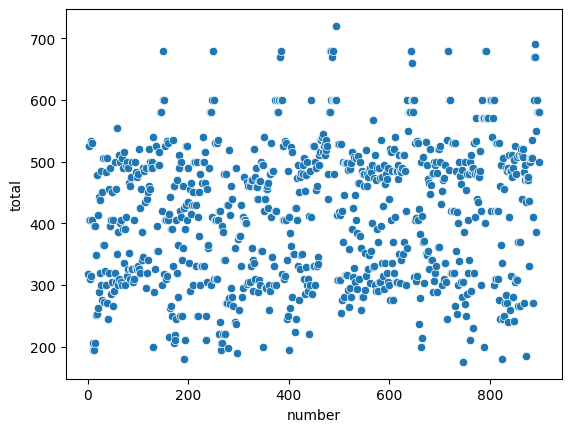

In [1252]:
sns.scatterplot(x='number', y='total', data=df)
plt.show()

No parece haber ningún valor demasiado alejado del promedio, con lo cual terminaremos el análisis exploratorio de datos.

### 2.4 Elección y análisis de características

Aunque ya terminó la fase del análisis exploratorio de datos, todavía se deben hacer adaptaciones al DataFrame antes de poderlo alimentar a los modelos.

In [1253]:
print(df.head())

   number        name  type1   type2  total  hp  attack  defense  sp_attack  \
0       1   Bulbasaur  Grass  Poison    318  45      49       49         65   
1       2     Ivysaur  Grass  Poison    405  60      62       63         80   
2       3    Venusaur  Grass  Poison    525  80      82       83        100   
5       4  Charmander   Fire    None    309  39      52       43         60   
6       5  Charmeleon   Fire    None    405  58      64       58         80   

   sp_defense  speed generation  legendary  
0          65     45          1      False  
1          80     60          1      False  
2         100     80          1      False  
5          50     65          1      False  
6          65     80          1      False  


Las variables 'number' y 'name' tienen como objetivo ser un identificador único de cada Pokémon, por lo tanto, no nos servirán para realizar predicciones, con lo que serán descartadas.

En este punto crearemos una copia del Dataset, pues si queremos analizar el éxito de nuestro modelo en Pokémones específicos necesitaremos su nombre y/o número, algo que no tendremos luego de eliminar estas variables.

In [1254]:
X = df.copy()
X.drop(['number', 'name'],axis=1, inplace=True)
print('Nuevo X con menos columnas: \n\n', X.head(), sep='')

Nuevo X con menos columnas: 

   type1   type2  total  hp  attack  defense  sp_attack  sp_defense  speed  \
0  Grass  Poison    318  45      49       49         65          65     45   
1  Grass  Poison    405  60      62       63         80          80     60   
2  Grass  Poison    525  80      82       83        100         100     80   
5   Fire    None    309  39      52       43         60          50     65   
6   Fire    None    405  58      64       58         80          65     80   

  generation  legendary  
0          1      False  
1          1      False  
2          1      False  
5          1      False  
6          1      False  


Uno de los mayores beneficios de utilizar modelos basados en árboles de decisión es la poca preparación que se le debe de hacer a los datos antes de entregárselos al modelo. De no utilizar este tipo de modelo tendríamos que
Normalizar o estandarizar el conjunto de datos; además de realizar preprocesamiento extra en caso de que tuviéramos variables de otro tipo, como lo pueden ser fechas.

Observemos también las variables 'type1', 'type2', 'generation' y 'legendary' (pues las demás variables son numéricas y ya han sido preprocesadas, pueden ser alimentadas al modelo tal como están).

* 'generation' es una variable categórica de tipo ordinal representada por números en orden, con lo cuál puede ser alimentada al modelo tal como está, pues Scikit-learn la tratará como una variable numérica común.

* 'legendary' es de tipo booleano, se la puede alimentar al modelo tal como está, como característica al igual que como etiqueta.

'type1' y 'type2' son más complicadas. El modelo no puede leer una variable categórica representada por texto, tampoco es una variable de tipo ordinal, con lo que la clase LabelEncoder de scikit-learn no será de ayuda, esto nos deja con dos posibilidades: Eliminar las variables del DataFrame de entrenamiento, o codificarlas utilizando la función get_dummies de Pandas.

Codificarlas es una alternativa **computacionalmente costosa**, aumentará el tiempo de entrenamiento de los modelos, su tiempo de predicción, y aumentará el tamaño de nuestro DataFrame considerablemente, por lo tanto, solo deberíamos de utilizarlas si estamos seguros de que estas variables aportan una gran cantidad de información ¿Cómo averiguamos esto?

Teniendo en cuenta que, al aumentar la cantidad de características del DataFrame, se puede aumentar el sobreajuste -algo a lo que tienden los modelos basados en árboles de decisión-, y sabiendo que, en el material de origen, los Pokémones legendarios son definidos principalmente por sus características altas, podemos borrar las variables categóricas de nuestro set de entrenamiento.

Sin embargo, hagamos un ejercicio netamente educativo: observemos el efecto de conservar estas variables en otro modelo diferente. Entrenaremos un DecisionTreeClassifier incluyendo las variables, y otro sin incluirlas, buscando predecir la etiqueta 'generation', en vez de nuestra etiqueta seleccionada 'legendary'.

___________________

## Ejercicio aislado

In [1255]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

ytemp = X['generation']
Xtemp = X.drop(['generation'], axis=1)

# Creamos un DataFrame sin 'type2' y otro con sus dummies
X_cat = Xtemp.copy()
X_cat = pd.get_dummies(X_cat, columns=['type1', 'type2'])
X_nocat = Xtemp.drop(['type1', 'type2'], axis=1)

# Entrenamos el modelo usando 'type2'
X_train, X_test, y_train, y_test = train_test_split(X_cat, ytemp, stratify=ytemp)

mdl_cat = GridSearchCV(DecisionTreeClassifier(),
                      {'max_depth': [5, 10, 20],
                       'min_samples_split': [2, 5, 10],
                       'min_samples_leaf': [1, 5, 10]})
mdl_cat.fit(X_train, y_train)

print("Puntaje del modelo con variables categóricas en entrenamiento: ",
      mdl_cat.score(X_train, y_train),
      "\nPuntaje del modelo con variables categóricas en testing: ",
      mdl_cat.score(X_test, y_test),
      '\n', sep='')

# Entrenamos el modelo sin usar 'type2'
X_train, X_test, y_train, y_test = train_test_split(X_nocat, ytemp, stratify=ytemp)

mdl_nocat = GridSearchCV(DecisionTreeClassifier(),
                        {'max_depth': [5, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'min_samples_leaf': [1, 5, 10]})
mdl_nocat.fit(X_train, y_train)

print("Puntaje del modelo sin variables categóricas en entrenamiento: ",
      mdl_nocat.score(X_train, y_train),
      "\nPuntaje del modelo sin variables categóricas en testing: ",
      mdl_nocat.score(X_test, y_test), sep='')

Puntaje del modelo con variables categóricas en entrenamiento: 0.30030959752321984
Puntaje del modelo con variables categóricas en testing: 0.20833333333333334

Puntaje del modelo sin variables categóricas en entrenamiento: 0.5185758513931888
Puntaje del modelo sin variables categóricas en testing: 0.16666666666666666


En este caso, incluir las variables categóricas parece mejorar la generalización del modelo, dándole mejor desempeño en variables no vistas. Para saber qué tanto le aportan estas variables al modelo, utilizaremos el atributo feature_importances_.

In [1256]:
coeficients = pd.DataFrame(mdl_cat.best_estimator_.feature_importances_,
                            index=mdl_cat.feature_names_in_, columns=['coeficientes con variables'])
coeficients.join(pd.DataFrame(mdl_nocat.best_estimator_.feature_importances_,
                               index=mdl_nocat.feature_names_in_,
                               columns=['coeficientes sin variables']))

,coeficientes con variables,coeficientes sin variables
total,0.248025,0.212595
hp,0.147968,0.119102
attack,0.005126,0.150170
defense,0.158307,0.092529
sp_attack,0.114268,0.099109
sp_defense,0.000000,0.146212
speed,0.119196,0.180283
legendary,0.000000,0.000000
type1_Bug,0.000000,NaN
type1_Dark,0.000000,NaN


En este caso, podemos ver que solo unas pocas categorías son relevantes, la mayoría tienen un valor de 0. Tal vez otro modelo más complejo podría saber aprovechar estas características extra. De cualquier forma, este ejercicio corto solo fue realizado para demostrar el uso del atributo feature_importances_. Volvamos ahora a nuestro proyecto.

_____________________________

Procedemos a remover las variables categóricas del Dataset de entrenamiento.

In [1257]:
X = X.drop(['type1', 'type2', 'generation'], axis=1)

print(X.head())

   total  hp  attack  defense  sp_attack  sp_defense  speed  legendary
0    318  45      49       49         65          65     45      False
1    405  60      62       63         80          80     60      False
2    525  80      82       83        100         100     80      False
5    309  39      52       43         60          50     65      False
6    405  58      64       58         80          65     80      False


Esta 'X' será el DataFrame con el que entrenemos todos nuestros modelos. La 'y' será una copia de la columna 'legendary'.

Con esto termina la sección de preprocesamiento.

## 3. Entrenamiento de los modelos

En este proyecto, buscaremos predecir la etiqueta 'legendary' usando las variables de tipo numéricas. Esta es una clasificación binaria que, al estudiar el material de origen, sabemos que está altamente correlacionada con las estadísticas de combate de los Pokémones.

### 3.1 Entrenamiento inicial de los modelos

Iniciaremos por crear un nuevo 'y' que contenga los valores de 'legendary', y una copia de X suprimiendo la columna 'legendary'.

In [1258]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,\
 GradientBoostingClassifier


yleg = X['legendary']
Xleg = X.drop('legendary', axis=1)

X_train, X_test, y_train, y_test = train_test_split(Xleg, yleg, stratify=yleg)

print(Xleg, yleg)

      total   hp  attack  defense  sp_attack  sp_defense  speed
0       318   45      49       49         65          65     45
1       405   60      62       63         80          80     60
2       525   80      82       83        100         100     80
5       309   39      52       43         60          50     65
6       405   58      64       58         80          65     80
...     ...  ...     ...      ...        ...         ...    ...
1065    580   80     100       50        100          50    200
1066    580  200     100       50        100          50     80
1067    580  100     145      130         65         110     30
1068    580  100      65       60        145          80    130
1069    500  100      80       80         80          80     80

[862 rows x 7 columns] 0       False
1       False
2       False
5       False
6       False
        ...  
1065     True
1066     True
1067     True
1068     True
1069     True
Name: legendary, Length: 862, dtype: bool


como recordatorio, buscaremos predecir la etiqueta 'legendary' usando las variables de tipo numéricas. Esta es una clasificación binaria que, al estudiar el material de origen, sabemos que está altamente correlacionada con las estadísticas de combate de los Pokémones.
Iniciaremos por crear un nuevo 'y' que contenga los valores de 'legendary', y una copia de X suprimiendo la columna 'legendary'.
Como recordatorio, entrenaremos cuatro modelos que tienen los siguientes nombres en Scikit-learn:

1. DecisionTreeClassifier
2. RandomForestClassifier
3. ExtraTreesClassifier
4. GradientBoostingClassifier

* DecisionTreeClassifier, es el modelo base que utilizan los otros tres, sufre problemas de sobreajuste y solamente tiene un buen desempeño encontrando relaciones simples. Sin embargo, los otros modelos se basan en el entrenamiento de conjuntos de árboles de decisión, fortaleciendo los puntos débiles del modelo individual a cambio de mayores tiempos de entrenamiento y predicción.

* Random Forest entrena una cantidad n de árboles de decisión utilizando filas y columnas aleatorias cada vez, después los guarda en su memoria. Cuando va a realizar una predicción, los n árboles realizan sus predicciones individualmente para después ser promediadas; el resultado final es la predicción con el valor promedio más alto.

* Extra Trees Classifier es una versión de Random Forest que introduce una mayor aleatoriedad y, con ella, un mayor control del sobreajuste al que tienden estos modelos. Funciona de la misma forma que el Random Forest, pero esta aleatoriedad extra implica mayores costos computacionales.

* Gradient Boosting Decision Tree, es un único árbol de decisión que se entrena múltiples veces. Con cada iteración, el árbol aprenderá de la iteración anterior e intentará corregir los errores de su predecesor. El resultado final es un único árbol -a diferencia de los n árboles de los modelos anteriores-, generando así predicciones más rápidamente.

Para entrenar estos modelos, utilizaremos una clase llamada GridSearchCV, esta clase buscará la mejor combinación de parámetros dentro de una lista dada por nosotros, aplicando cross-validation cada vez. Esta clase es computacionalmente costosa y su tiempo de ejecución aumenta exponencialmente entre más parámetros se le dan, con lo que debe ser usada con precaución, especialmente en Datasets grandes y en modelos altamente complejos como redes neuronales.

En este caso, la clase fue corrida con anterioridad y sus parámetros resultantes guardados, si quiere realizar de nuevo el proceso de encontrar los hiperparámetros para comprobar los resultados, descomente el código que hay en cada celda.

Ahora, entrenemos los modelos. Entrenaremos cada uno en una celda diferente para no tener que correr todos a la vez si queremos realizar un cambio a alguno en específico.


In [1259]:
from sklearn.ensemble import RandomForestClassifier,\
ExtraTreesClassifier, GradientBoostingClassifier

# Código para encontrar los mejores parámetros

'''
gs = GridSearchCV(DecisionTreeClassifier(),
                  {'max_depth': [5, 10, 20],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 5, 10]})
tree = gs.fit(X_train, y_train).best_estimator_
'''

# Entrenamiento con los parámetros encontrados
tree = DecisionTreeClassifier(max_depth=5,
                              min_samples_split=2,
                              min_samples_leaf=10)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)

In [1260]:
# Código para encontrar los mejores parámetros

'''
gs = GridSearchCV(RandomForestClassifier(),
                  {'n_estimators': [100, 200],
                   'max_depth': [10, 20, 30],
                   'min_samples_split': [2, 5],
                   'min_samples_leaf': [1, 2],
                   'max_features': ['sqrt', 'log2']})
forest = gs.fit(X_train, y_train).best_estimator_
'''

# Entrenamiento con los parámetros encontrados
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=10,
                                min_samples_split=2,
                                min_samples_leaf=1)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [1261]:
# Código para encontrar los mejores parámetros

'''
gs = GridSearchCV(ExtraTreesClassifier(),
                  {'n_estimators': [100, 200],
                   'max_depth': [10, 20, 30],
                   'min_samples_split': [2, 5],
                   'min_samples_leaf': [1, 2],
                   'max_features': ['sqrt', 'log2']})
extra = gs.fit(X_train, y_train).best_estimator_
'''

# Entrenamiento con los parámetros encontrados
extra = ExtraTreesClassifier(n_estimators=100,
                             max_depth=20,
                             min_samples_split=2,
                             min_samples_leaf=1)
extra.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=20)

In [1262]:
# Código para encontrar los mejores parámetros

'''
gs = GridSearchCV(GradientBoostingClassifier(),
                  {'n_estimators': [150, 200],
                   'learning_rate': [0.01, 0.05, 0.1],
                   'max_depth': [3, 5, 7],
                   'subsample': [0.8, 1.0]})
gradient = gs.fit(X_train, y_train).best_estimator_
'''

# Entrenamiento con los parámetros encontrados
gradient = GradientBoostingClassifier(n_estimators=200,
                                      learning_rate=0.05,
                                      max_depth=7,
                                      subsample=0.8)
gradient.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=7, n_estimators=200,
                           subsample=0.8)

In [1263]:
# Función que recibe una lista de modelos y devuelve su puntaje de exactitud
def evaluar(models):
  results = []
  for model in models:
    results.append((
        model.score(X_train, y_train),
        model.score(X_test, y_test),
    ))
  return results

results = evaluar([tree, forest, extra, gradient])

print('Puntajes del árbol individual\n\nTrain:', results[0][0],
      '\nTest:', results[0][1])
print('\nPuntajes del random forest\n\nTrain:', results[1][0],
      '\nTest:', results[1][1])
print('\nPuntajes del extra trees\n\nTrain:', results[2][0],
      '\nTest:', results[2][1])
print('\nPuntajes del gradient boosting classifier\n\nTrain:', results[3][0],
      '\nTest:', results[3][1])

Puntajes del árbol individual

Train: 0.9767801857585139 
Test: 0.9675925925925926

Puntajes del random forest

Train: 1.0 
Test: 0.9675925925925926

Puntajes del extra trees

Train: 1.0 
Test: 0.9722222222222222

Puntajes del gradient boosting classifier

Train: 1.0 
Test: 0.9814814814814815


En este caso, debido al tamaño relativamente pequeño del DataFrame y a la simplicidad del modelo, el entrenamiento con GridSearchCV no tomó mucho tiempo, sin embargo, para modelos o DataFrames más complejos, el tiempo de entrenamiento se puede convertir en un verdadero desafío. Si queremos reducir este tiempo, podemos tomar algunas acciones como:

* Reducir la cantidad de parámetros presentes en el param_grid de GridSearchCV o, en su defecto, reducir la cantidad de opciones presentes en cada parámetro.

* Asignarle un valor cv < 5 a GridSearchCV, esto significa que GridSearchCV realizará menos cross-validations por cada entrenamiento, pues por defecto realiza cinco.

* Revisitar el DataFrame de entrenamiento y buscar formas de reducir su dimensionalidad.


### 3.2 Análisis de desempeño

Puede que el puntaje de exactitud de los modelos parezca muy bueno, sin embargo, debemos tener en cuenta varias cosas a la hora de analizar su rendimiento:

* Todos los modelos menos el árbol individual están sobre ajustando, como se evidencia por su puntaje perfecto en el set de entrenamiento ¿Podemos mejorar su rendimiento haciéndolos generalizar más?

*  Las etiquetas están desbalanceadas: el DataFrame contiene un total de 79 legendarios (9.2%) y 783 (90.8%) no-legendarios, entonces ¿Nuestro modelo de verdad está prediciendo bien? ¿O simplemente **parece** estar prediciendo bien debido al desbalance?

Primero lidiaremos con el tema del desbalance, para averiguar si nuestros modelos están prediciendo bien, entrenaremos un DummyClassifier; un clasificador que siempre predecirá la moda de los valores (en este caso, False), y compararemos su desempeño con nuestro mejor modelo, el Gradient Boosting Classifier.

Después de esto, observaremos la matriz de confusión del gradient boosting classifier para observar más a fondo sus errores y diagnosticarlos.


In [1264]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

results = evaluar([dummy, gradient])

print('Puntajes del dummy classifier\n\nTrain:', results[0][0],
      '\nTest:', results[0][1])
print('\nPuntajes del gradient boosting tree\n\nTrain:', results[1][0],
      '\nTest:', results[1][1])

Puntajes del dummy classifier

Train: 0.9086687306501547 
Test: 0.9074074074074074

Puntajes del gradient boosting tree

Train: 1.0 
Test: 0.9814814814814815


Observemos primero la matriz de confusión del dummy classifier.

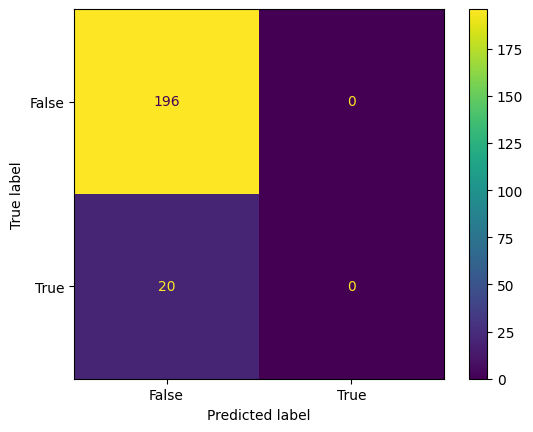

In [1265]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

dum_ypred = dummy.predict(X_test)

dum_matrix = confusion_matrix(y_test, dum_ypred)
dum_display = ConfusionMatrixDisplay(confusion_matrix=dum_matrix,
                                 display_labels=dummy.classes_)
dum_display.plot()

Ahora observemos la del Gradient Boosting Classifier.

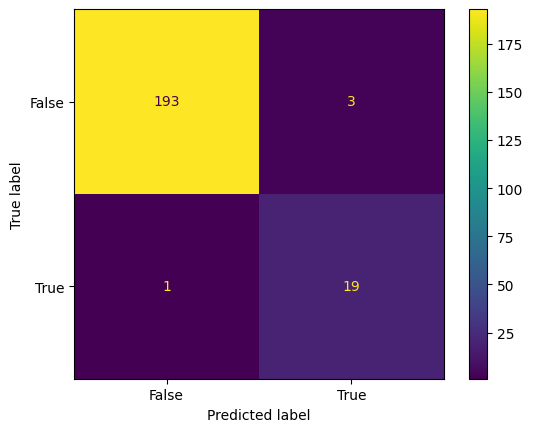

In [1266]:
ypred = gradient.predict(X_test)

matrix = confusion_matrix(y_test, ypred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                 display_labels=gradient.classes_)
display.plot()

Ahora que tenemos la matriz de confusión, podemos observar más a fondo los resultados y hacer un mejor análisis:

* 19 de los 20 Pokémones legendarios fueron clasificados como legendarios.

* 19 de los 22 Pokémones a los que el modelo clasificó como legendarios, fueron clasificados correctamente.

El modelo tiene un desempeño bueno, sin embargo, viéndolo de esta forma no se parece al 98% de exactitud que nos había sido indicado anteriormente, ¿verdad? Esto se debe a que la métrica de exactitud es la más simple y directa de todas, mide predicciones correctas sobre predicciones totales.

Si tenemos un DataFrame desbalanceado esta medida no es muy realista, tampoco sirve si tenemos prioridades específicas (por ejemplo, si queremos clasificar a **todos** los legendarios correctamente, incluso si eso implica clasificar algunos no legendarios como legendarios). En estos casos, tenemos tres medidas útiles: Precision, Recall, y F1-score.


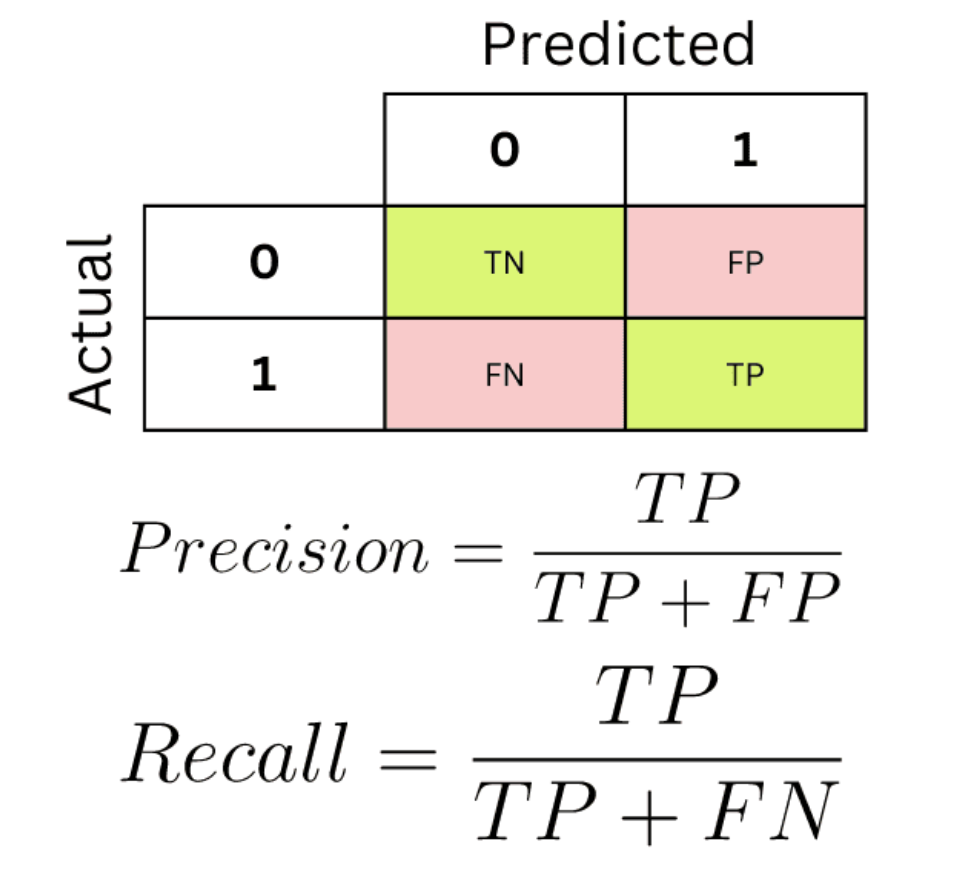

Imagen tomada de: https://medium.com/@weidagang/demystifying-precision-and-recall-in-machine-learning-6f756a4c54ac

* Precision: Esta medida evalúa únicamente las instancias donde el modelo da una predicción positiva. toma los verdaderos positivos y los divide por la suma de los verdaderos positivos y falsos positivos.

En el caso de este modelo, precision: (19 / (19 + 3)) = 0.86

* Recall: Esta medida evalúa únicamente las instancias donde la etiqueta verdadera era positiva. toma los verdaderos positivos y los divide por la suma de los verdaderos positivos y los falsos negativos.

En el caso de este modelo, recall: (19 / (19 + 1)) = 0.95

* F1-score: Esta medida es una combinación de las dos anteriores, su fórmula es la multiplicación de precision y recall por 2, dividido la suma de precision y recall, o en nuestro caso:

(2 * 0.86 * 0.95 / (0.86 + 0.95)) = 0.90

Comprobemos nuestros cálculos con las funciones de scikit-learn antes de continuar.


In [1267]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision:', round(precision_score(y_test, ypred), 2))
print('Recall:', recall_score(y_test, ypred))
print('F1-score:', round(f1_score(y_test, ypred), 2))

Precision: 0.86
Recall: 0.95
F1-score: 0.9


Ahora, evaluemos nuevamente el desempeño de todos los modelos ya entrenados, esta vez usando el F1-score.

In [1268]:
def evaluar_f1(models):
  results = []
  for model in models:
    results.append((
        f1_score(y_train, model.predict(X_train)),
        f1_score(y_test, model.predict(X_test)),
    ))
  return results

results = evaluar_f1([tree, forest, extra, gradient])

print('Puntajes del árbol individual\n\nTrain:', results[0][0],
      '\nTest:', results[0][1])
print('\nPuntajes del random forest\n\nTrain:', results[1][0],
      '\nTest:', results[1][1])
print('\nPuntajes del extra trees\n\nTrain:', results[2][0],
      '\nTest:', results[2][1])
print('\nPuntajes del gradient boosting classifier\n\nTrain:', results[3][0],
      '\nTest:', results[3][1])

Puntajes del árbol individual

Train: 0.8739495798319329 
Test: 0.8444444444444444

Puntajes del random forest

Train: 1.0 
Test: 0.8444444444444444

Puntajes del extra trees

Train: 1.0 
Test: 0.8571428571428572

Puntajes del gradient boosting classifier

Train: 1.0 
Test: 0.9047619047619048


Siguen siendo resultados decentes, pero ahora podemos ver más claramente los efectos del sobreajuste y el potencial de mejoría que hay en cada modelo (en especial en el Random Forest, cuyo desempeño en datos nuevos es igual o peor al del árbol individual).

### 3.3 Ajuste de los modelos

Recordemos que el entrenamiento y ajuste de modelos **es un proceso iterativo**, nuestro primer modelo nunca será perfecto y, de hecho, rara vez será útil. Teniendo esto en cuenta, realizaremos una segunda iteración de entrenamientos en búsqueda de una mejoría en el puntaje F1.

Entrenemos los modelos de nuevo, ahora utilizando en GridSearchCV la métrica de evaluación 'f1' e incluyendo en la búsqueda parámetros que castiguen el sobreajuste (No volveremos a entrenar el árbol individual, pues no sufre de un sobreajuste relevante y simplificarlo más afectaría negativamente su rendimiento).


In [1269]:
# Código para encontrar los mejores parámetros

'''
gs = GridSearchCV(RandomForestClassifier(),
                  {'n_estimators': [100, 150, 200],
                   'max_depth': [7, 10, 20],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 3],
                   'max_features': ['sqrt'],
                   'max_samples': [0.8, 0.9]},
                  scoring='f1')
forest = gs.fit(X_train, y_train).best_estimator_
'''

# Entrenamiento con los parámetros encontrados
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=10,
                                min_samples_split=5,
                                min_samples_leaf=1,
                                max_features='sqrt',
                                max_samples=0.8)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_samples=0.8, min_samples_split=5)

In [1270]:
# Código para encontrar los mejores parámetros

'''
gs = GridSearchCV(ExtraTreesClassifier(),
                  {'n_estimators': [100, 150, 200],
                   'max_depth': [7, 10, 15, 20],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 5],
                   'max_features': ['sqrt'],
                   'max_samples': [0.7, 0.8, 0.9],
                   'bootstrap': [True]},
                  scoring='f1')
extra = gs.fit(X_train, y_train).best_estimator_
'''


# Entrenamiento con los parámetros encontrados
extra = ExtraTreesClassifier(n_estimators=100,
                             max_depth=15,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_features='sqrt',
                             max_samples=0.7,
                             bootstrap=True)
extra.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, max_depth=15, max_samples=0.7)

In [1271]:
# Código para encontrar los mejores parámetros

'''
gs = GridSearchCV(GradientBoostingClassifier(),
                  {'n_estimators': [100, 150, 200],
                   'learning_rate': [0.01, 0.05, 0.1],
                   'max_depth': [3, 5, 7],
                   'min_samples_split': [3, 5, 10],
                   'min_samples_leaf': [2, 4, 6],
                   'subsample': [0.8, 1.0]},
                  scoring='f1')
gradient = gs.fit(X_train, y_train).best_estimator_
'''

# Entrenamiento con los parámetros encontrados
gradient = GradientBoostingClassifier(n_estimators=200,
                                      learning_rate=0.01,
                                      max_depth=3,
                                      min_samples_split=3,
                                      min_samples_leaf=2,
                                      subsample=1.0)
gradient.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=2,
                           min_samples_split=3, n_estimators=200)

In [1272]:
results = evaluar_f1([forest, extra, gradient])

print('\nPuntajes del random forest\n\nTrain:', results[0][0],
      '\nTest:', results[0][1])
print('\nPuntajes del extra trees\n\nTrain:', results[1][0],
      '\nTest:', results[1][1])
print('\nPuntajes del gradient boosting classifier\n\nTrain:', results[2][0],
      '\nTest:', results[2][1])


Puntajes del random forest

Train: 0.9203539823008849 
Test: 0.8636363636363635

Puntajes del extra trees

Train: 0.9649122807017544 
Test: 0.8780487804878048

Puntajes del gradient boosting classifier

Train: 0.9203539823008849 
Test: 0.9047619047619048


Los nuevos parámetros que castigan más el sobreajuste lograron resultados interesantes y, hasta cierto punto, inesperados. Analicemos los cambios que se presentaron en cada uno de los modelos:

* Random Forest logró un mejor desempeño en general, reduciendo su puntaje f1 en el DataFrame de entrenamiento, pero mejorando su puntaje en el de testing. Se logra el objetivo, sin embargo, no llega a tener un rendimiento tan bueno como el del Gradient Boosting Classifier.

* Extra Trees es un caso interesante, pues si bien añadir nuevos parámetros parece haber mejorado su desempeño en el DataFrame de testeo y reducir su desempeño en el de entrenamiento, **este no es siempre el caso**, pues la implementación de los parámetros 'max_samples' y 'bootstrap' le añaden aleatoriedad a un modelo que ya de por sí es aleatorio e inconsistente. Como consecuencia, cada vez que entrenemos el modelo tendrá un resultado diferente.

* Gradient Boosting Classifier nos demuestra algo: el modelo no puede mejorar más a menos de que memorice cada entrada. Por más que se reduzca la complejidad del modelo, hay un subconjunto de datos que simplemente no podrá predecir apropiadamente a menos de que los haya visto antes. Analizaremos esto más a fondo en la sección de conclusiones de este Notebook.

Utilizaremos estos modelos -en especial gradient- para nuestro análisis de resultados y conclusiones.

## 4. Análisis de resultados

Primero realizaremos una comparación entre los tres modelos, posteriormente, utilizaremos el modelo con mejor desempeño para realizar predicciones y analizaremos estas predicciones.

### 4.1 Selección de modelo

Graficaremos el puntaje F1 obtenido anteriormente para una mejor visualización

In [1273]:
results = pd.DataFrame(results,
                       index=['Forest', 'Extra', 'Gradient'],
                       columns=['Train', 'Test'])
print(results)

             Train      Test
Forest    0.920354  0.863636
Extra     0.964912  0.878049
Gradient  0.920354  0.904762


Text(0, 0.5, 'Puntaje F1')

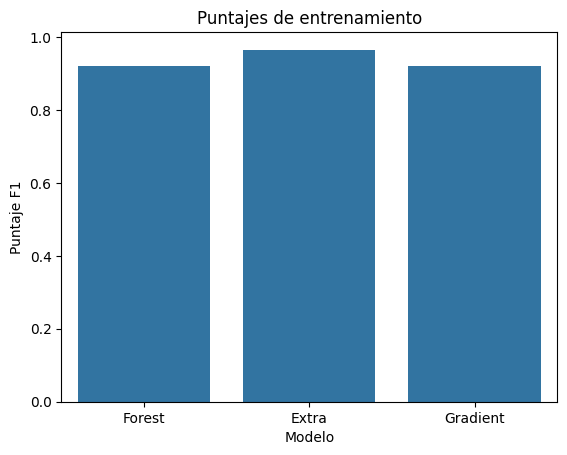

In [1274]:
sns.barplot(x=results.index, y=results['Train'])
plt.title('Puntajes de entrenamiento')
plt.xlabel('Modelo')
plt.ylabel('Puntaje F1')

Text(0, 0.5, 'Puntaje F1')

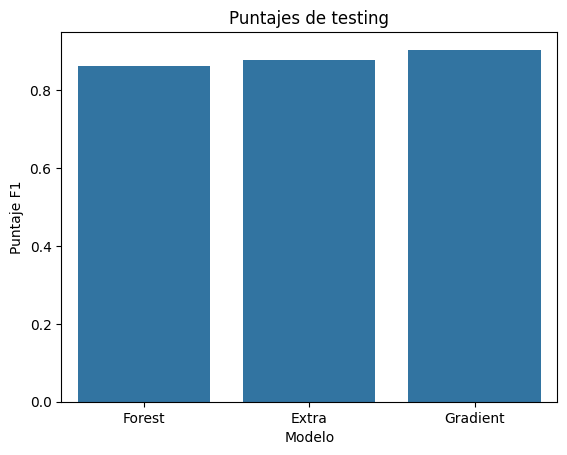

In [1275]:
sns.barplot(data=results, y='Test', x=results.index)
plt.title('Puntajes de testing')
plt.xlabel('Modelo')
plt.ylabel('Puntaje F1')

Los puntajes de entrenamiento están bastante dispersos, pero en los puntajes de testing hay un claro ganador: el Gradient Boosting Classifier. Por lo tanto, utilizaremos este modelo para realizar predicciones sobre nuestro dataset inicial preprocesado, así podremos observar mejor cuáles son los casos puntuales en los que se equivoca, sacar conclusiones de esto y elaborar planes a futuro en caso de que quisiéramos seguir refinando el modelo.

**Puede** que, en algunas iteraciones, el modelo Extra Trees tenga mejor desempeño en entrenamiento e igual desempeño en testing que el modelo gradient, sin embargo, su aleatoriedad lo hace inviable. Aun así, si durante el entrenamiento conseguimos una versión muy buena del Extra Trees y la queremos guardar, podemos hacerlo con la librería pickle, utilizando el siguiente código:

In [1276]:
import pickle


print(extra)

# Código para guardar el modelo usando Pickle
with open('extra_trees.pkl', 'wb') as f:
  pickle.dump(extra, f)

# Código para cargar el modelo usando Pickle
with open('extra_trees.pkl', 'rb') as f:
  extra = pickle.load(f)

print(extra)

ExtraTreesClassifier(bootstrap=True, max_depth=15, max_samples=0.7)
ExtraTreesClassifier(bootstrap=True, max_depth=15, max_samples=0.7)


Antes de proceder, hay algo más que debemos de analizar: los coeficientes aprendidos por el modelo. Estos coeficientes representan la importancia de las características de cada entrada para las predicciones realizadas.

Es importante conocer estos coeficientes en caso de que queramos hacer iteraciones posteriores o reducir la dimensionalidad de nuestro DataFrame, pues una característica con un valor muy bajo de coeficiente puede estar aportando únicamente ruido al modelo.

In [1277]:
coeficients = pd.DataFrame(gradient.feature_importances_,
                           index=gradient.feature_names_in_,
                           columns=['coeficientes'])
print(coeficients)

            coeficientes
total           0.904326
hp              0.022308
attack          0.048207
defense         0.001007
sp_attack       0.009508
sp_defense      0.013414
speed           0.001229


'defense' y 'speed' no parecen estar aportando mucho al modelo, probablemente podríamos desecharlas sin perder rendimiento, sin embargo, las conservaremos para tener todas las estadísticas de combate del Dataset original y hacer las predicciones más sencillas de redactar.

Ahora, utilicemos el modelo gradient para realizar predicciones y analicémoslas.

### 4.2 Predicciónes y análisis

Realizaremos las predicciones sobre el Dataframe preprocesado original, df, para analizar el desempeño del modelo y, especialmente, para observar los puntos donde se equivocó.

Después de calcular algunas medidas como la matriz de confusión y el puntaje F1, recopilaremos la información que nos brindan.

In [1278]:
df['prediction'] = gradient.predict(df.loc[:,'total':'speed'])

print(df)

      number        name     type1   type2  total   hp  attack  defense  \
0          1   Bulbasaur     Grass  Poison    318   45      49       49   
1          2     Ivysaur     Grass  Poison    405   60      62       63   
2          3    Venusaur     Grass  Poison    525   80      82       83   
5          4  Charmander      Fire    None    309   39      52       43   
6          5  Charmeleon      Fire    None    405   58      64       58   
...      ...         ...       ...     ...    ...  ...     ...      ...   
1065     894   Regieleki  Electric    None    580   80     100       50   
1066     895   Regidrago    Dragon    None    580  200     100       50   
1067     896   Glastrier       Ice    None    580  100     145      130   
1068     897   Spectrier     Ghost    None    580  100      65       60   
1069     898     Calyrex   Psychic   Grass    500  100      80       80   

      sp_attack  sp_defense  speed generation  legendary  prediction  
0            65          65 

Primero, observemos la nueva matriz de confusión que se forma cuando tomamos todo el Dataset en consideración.

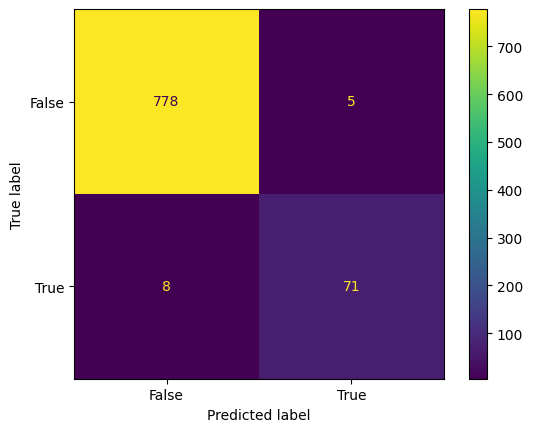

In [1279]:
matrix = confusion_matrix(df['legendary'], df['prediction'])
display = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                 display_labels=gradient.classes_)
display.plot()

Calculemos también el nuevo puntaje F1.

In [1280]:
print(f1_score(df['legendary'], df['prediction']))

0.9161290322580645


Ahora, observemos los casos en que el modelo **se equivocó**

In [1281]:
errores = df[df['legendary'] != df['prediction']]

print('cantidad total de errores:', len(errores),'\n')
print(errores)

cantidad total de errores: 13 

      number                         name     type1     type2  total   hp  \
538      445                     Garchomp    Dragon    Ground    600  108   
592      489                       Phione     Water      None    480   80   
677      567                     Archeops      Rock    Flying    567   75   
747      635                    Hydreigon      Dark    Dragon    600   92   
846      718            Zygarde 10% Forme    Dragon    Ground    486   54   
923      784                      Kommo-O    Dragon  Fighting    600   75   
928      789                       Cosmog   Psychic      None    200   43   
929      790                      Cosmoem   Psychic      None    400   43   
950      808                       Meltan     Steel      None    300   46   
1051     887                    Dragapult    Dragon     Ghost    600   88   
1058     891                        Kubfu  Fighting      None    385   60   
1059     892  Urshifu Single Strike Style  F

Finalmente, compilemos toda la información que estas medidas nos brindan:

* El modelo tiene una mayor tendencia a clasificar Pokémones legendarios como comunes, que a clasificar comunes como legendarios. Esto significa que tiene mayor precisión que recall. Sin embargo, observando los valores específicos que dejó pasar como comunes, podemos ver que varios de ellos son pre-evoluciones o fases iniciales -es decir, Pokémones legendarios débiles por diseño- (Zygarde 10%, Cosmog, Cosmoem, Meltan, Kubfu, Calyrex) mientras otros como Urshifu y Phione son simplemente débiles.

* Los Pokémones comunes a los que clasificó como legendarios tienen estadísticas sumamente altas. Para poder diferenciarlos de los legendarios necesitaríamos un modelo más complejo y un Dataset más completo con información como, por ejemplo, sus habilidades y ataques.

* Incluso utilizando la métrica F1, que tiene en cuenta el desbalance de clases, obtenemos un puntaje bastante decente. Este puntaje podría ser mejorado ajustando el modelo para que tenga un mejor desempeño con los datos de entrenamiento, pero esto afectaría negativamente su capacidad para generalizar que, verdaderamente, es el objetivo del modelo.

## 5. Conclusiones

Estos son algunos de los logros que conseguimos a lo largo de este proyecto:

* Realizamos un preprocesamiento a profundidad de un Dataset desbalanceado, aplicando técnicas de análisis estadístico; realizando análisis exploratorio de datos; imputando valores faltantes; identificando y eliminando valores atípicos; preparando datos de tipo categóricos y, finalmente, preparando el Dataset para poder entrenar apropiadamente los modelos.

* Entrenamos tres modelos diferentes a lo largo de dos iteraciones, lidiando con el problema del sobreajuste sin simplificar demasiado los modelos; hicimos comparaciones entre estos teniendo en cuenta el desbalance y utilizando las métricas apropiadas; escogimos un modelo consistente, con un buen desempeño en el DataFrame de prueba y una buena capacidad de generalización.

* Realizamos predicciones con el modelo de mejor rendimiento; observamos su matriz de confusión para encontrar las tendencias dentro de sus errores; analizamos sus errores y encontramos sus causas.

Finalmente, logramos entrenar un modelo con un puntaje F1 del 0.91, una medida bastante buena considerando el tamaño relativamente reducido del Dataset inicial. Además, logramos observar que el modelo tiene una buena capacidad para encontrar outliers (Pokémones comunes con estadísticas tan altas como las de los legendarios).

El objetivo del proyecto fue logrado: construimos un modelo funcional que logra predicciones acertadas rápidamente y con relativamente poca información. Los objetivos educacionales del proyecto también fueron alcanzados, pues se encontraron, explicaron y resolvieron múltiples situaciones problema a lo largo del preprocesamiento y entrenamiento del modelo.

_______________________

Este proyecto cubrió muchas de las bases necesarias para el diseño de modelos de Machine Learning, sin embargo, todavía quedan más temas y situaciones problema que no encontramos en este DataFrame ni con estos modelos, es por esto que siempre es necesario seguir practicando y aprendiendo.

Como un reto adicional para el lector, podría intentar entrenar otros modelos no basados en árboles de decisión con este mismo Dataset y observar los cambios en rendimiento y tiempo de entrenamiento.